# Advanced Macroeconomics 1: Homework 3

## Settings

In [1]:
######################################################
# 📦 Package Imports
######################################################

# === Data Manipulation ===
import pandas as pd                # DataFrame handling
import numpy as np                # Numerical operations
import random                     # For reproducibility

# === Visualization ===
import matplotlib.pyplot as plt   # General plotting
import seaborn as sns             # Statistical visualization

# === Time Series & Statistical Models ===
import statsmodels.api as sm
from statsmodels.tsa.stattools import (
    adfuller,                     # Augmented Dickey-Fuller Test
    kpss,                         # KPSS Test
    acf, pacf                     # Autocorrelation functions
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import (
    plot_acf,                     # ACF plot
    plot_pacf                     # PACF plot
)
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box test
from statsmodels.tsa.api import VAR                      # VAR model
from arch.unitroot import PhillipsPerron, ZivotAndrews   # Unit root tests

# === Machine Learning Metrics ===
from sklearn.metrics import mean_squared_error           # Model evaluation

# === Optional External Data Sources ===
import ipeadatapy as ipea                                # IPEA database (optional)

# === Utilities ===
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# === Reproducibility ===
seed = 42
np.random.seed(seed)
random.seed(seed)

# === Custom Color ===
red_color = (162 / 255, 37 / 255, 56 / 255)


from support import plot_moving_stats, plot_var_diagnostics


from statsmodels.stats.diagnostic import acorr_lm


# cholesky
from numpy.linalg import cholesky
from scipy.stats import ortho_group


In [2]:
warnings.filterwarnings("ignore")

## Questions

### Question 1

Obtain the monthly time series for the following variables: IPCA inflation, IBC-Br (series 24363 from the Brazilian Central Bank), SELIC interest rate, commodity price index (series 27574 from the Central Bank), and the exchange rate. Construct a measure of the real interest rate using the IPCA as the deflator. Use data starting from January 2000.

With these series, estimate a Vector Autoregression (VAR) model using monthly data, imposing a recursive identification scheme (Cholesky decomposition). The ordering of the variables in the VAR should be as follows: IPCA inflation, real interest rate (constructed), commodity price index, IBC-Br, and exchange rate.

#### Data

In [3]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2805,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2806,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2807,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [4]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()


# Apply log transformation to the IPCA column
df_ipca['log_IPCA'] = np.log(df_ipca['IPCA'])

# Calculate the first difference of the log
df_ipca['Δlog_IPCA'] = df_ipca['log_IPCA'].diff().round(5)


df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

In [5]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation

# Apply log transformation
df_ibcbr['log_IBCBR'] = np.log(df_ibcbr['IBC-Br'])

# Calculate the first difference of the log
df_ibcbr['Δlog_IBC-Br'] = df_ibcbr['log_IBCBR'].diff().round(5)

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)

In [6]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

In [7]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()



# Apply log transformation to the IPCA column
df_commodity['log_Commodity_Price_Index'] = np.log(df_commodity['Commodity_Price_Index'])

# Calculate the first difference of the log
df_commodity['Δlog_CommodityPrice'] = df_commodity['log_Commodity_Price_Index'].diff().round(5)



df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)


In [8]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate', 
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()


# Apply log transformation to the IPCA column
df_fx['log_FX_Rate'] = np.log(df_fx['FX_Rate'])

# Calculate the first difference of the log
df_fx['Δlog_FX_Rate'] = df_fx['log_FX_Rate'].diff().round(5)


df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)


In [9]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

del df_ibcbr, df_ipca, df_selic, df_commodity, df_fx

In [10]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['Δlog_IPCA']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)


# Apply log transformation
df['Log_real_interest_rate'] = np.log(df['real_interest_rate'])

# Calculate the first difference of the log
df['ΔLog_real_interest_rate'] = df['Log_real_interest_rate'].diff().round(5)



df['real_interest_rate'] = df['real_interest_rate'].round(5)


In [11]:
# Select the variables of interest for the VAR
vars_var = df[['Δlog_IPCA', 'real_interest_rate', 'Δlog_CommodityPrice', 'Δlog_IBC-Br', 'Δlog_FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

Δlog_IPCA              0
real_interest_rate     0
Δlog_CommodityPrice    0
Δlog_IBC-Br            1
Δlog_FX_Rate           0
dtype: int64


#### Plot series

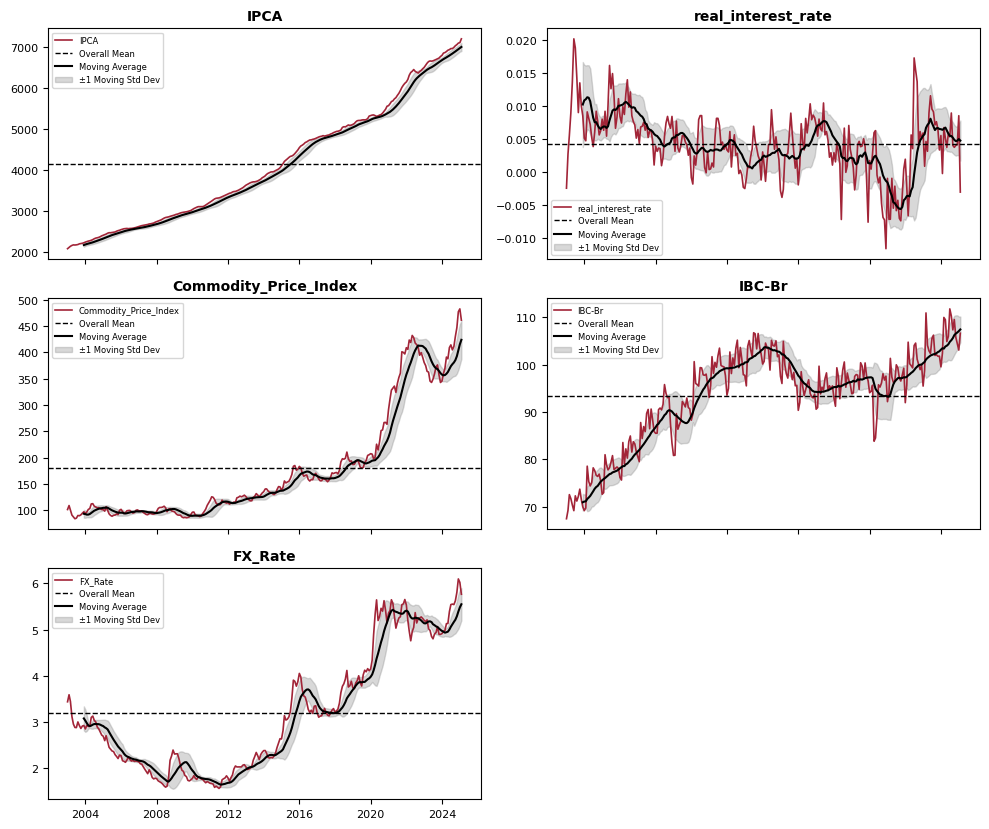

In [12]:
vars_var = df[['IPCA', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]


plot_moving_stats(vars_var, cols=vars_var.columns, window_size=12, line_color=red_color)

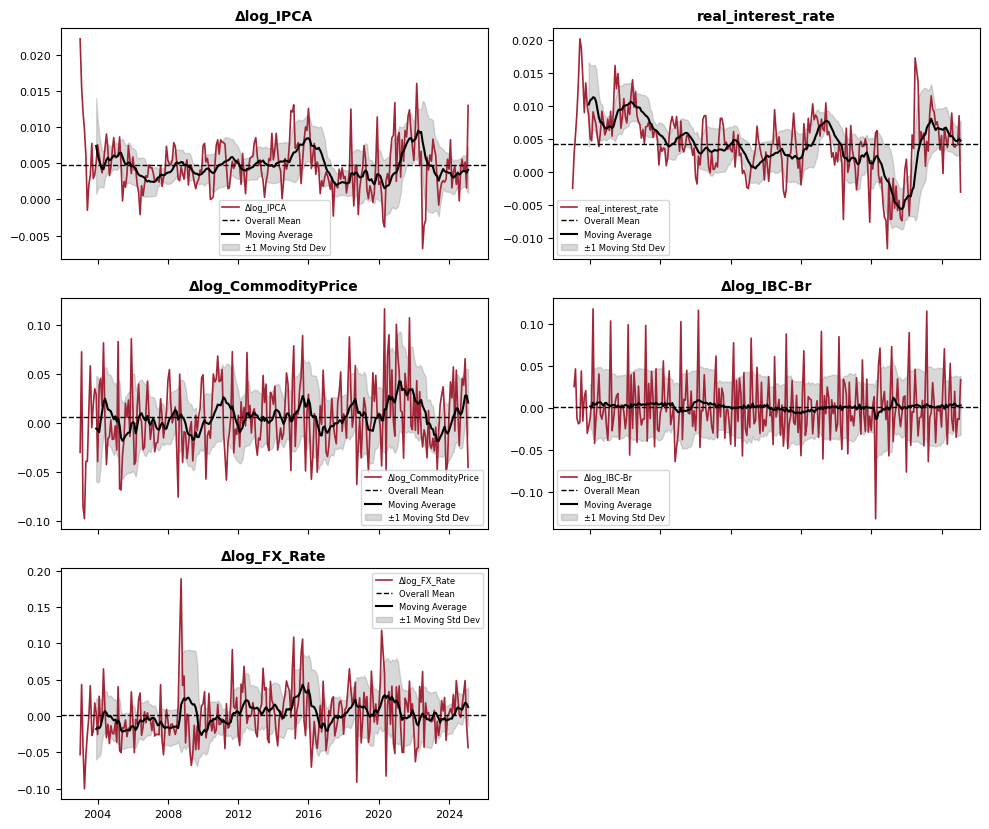

In [13]:
vars_var = df[['Δlog_IPCA', 'real_interest_rate', 'Δlog_CommodityPrice', 'Δlog_IBC-Br', 'Δlog_FX_Rate']]



plot_moving_stats(vars_var, cols=vars_var.columns, window_size=12, line_color=red_color)

#### Choose lags for VAR model based on AIC, SBC, and HQ criteria

In [14]:
vars_var = df[['Δlog_IPCA', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']]

# Fit VAR model
model = VAR(vars_var)

# Initialize dictionaries to store info criteria for each lag
aic_dict = {}
bic_dict = {}
hqic_dict = {}

# Test lags from 1 to 15
for lag in range(1, 16):
    result = model.fit(lag)
    aic_dict[lag] = result.aic
    bic_dict[lag] = result.bic
    hqic_dict[lag] = result.hqic

# Create DataFrame with all criteria
criteria_table = pd.DataFrame({
    'AIC': pd.Series(aic_dict),
    'BIC': pd.Series(bic_dict),
    'HQIC': pd.Series(hqic_dict)
})

print("Information Criteria by Lag:")
print(criteria_table)

# Find which lag each criterion selected
selected_orders = {
    'aic': criteria_table['AIC'].idxmin(),
    'bic': criteria_table['BIC'].idxmin(),
    'hqic': criteria_table['HQIC'].idxmin()
}

print("\nLag selected by each criterion:")
print(selected_orders)

# Count how many times each lag was selected
criteria_counts = Counter(selected_orders.values())
print("\nLag chosen by multiple criteria:")
print(criteria_counts)

# Choose the most common lag
most_common_lag = criteria_counts.most_common(1)[0][0]
print(f"\nFinal selected lag: {most_common_lag}")

# Fit final VAR model
results = model.fit(most_common_lag)


Information Criteria by Lag:
          AIC        BIC       HQIC
1  -24.122361 -23.717108 -23.959536
2  -24.587229 -23.842240 -24.287870
3  -24.838856 -23.752269 -24.402183
4  -24.954779 -23.524718 -24.380006
5  -24.996468 -23.221037 -24.282802
6  -25.128720 -23.006006 -24.275361
7  -25.389466 -22.917539 -24.395606
8  -25.438079 -22.614991 -24.302902
9  -25.481955 -22.305739 -24.204638
10 -25.555518 -22.024189 -24.135231
11 -25.812385 -21.923939 -24.248289
12 -26.003952 -21.756365 -24.295200
13 -26.071121 -21.462352 -24.216859
14 -26.037484 -21.065471 -24.036849
15 -26.190017 -20.852678 -24.042138

Lag selected by each criterion:
{'aic': np.int64(15), 'bic': np.int64(2), 'hqic': np.int64(3)}

Lag chosen by multiple criteria:
Counter({np.int64(15): 1, np.int64(2): 1, np.int64(3): 1})

Final selected lag: 15


#### Estimate the VAR model and perform the diagnostic/specification tests as discussed in class.

In [15]:
lags = 15

In [16]:

# Select variables and drop missing values
cols = ['Δlog_IPCA', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
df_var = df[cols].dropna()

# Estimate VAR(15) model using OLS
model = VAR(df_var)
results = model.fit(lags, method='ols')

# Print summary
print(results.summary())



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, May, 2025
Time:                     09:52:14
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -20.8527
Nobs:                     251.000    HQIC:                  -24.0421
Log likelihood:           1886.08    FPE:                4.65987e-12
AIC:                     -26.1900    Det(Omega_mle):     1.24166e-12
--------------------------------------------------------------------
Results for equation Δlog_IPCA
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.000252         0.004769            0.053           0.958
L1.Δlog_IPCA                      0.598205         0.338783            1.766           0.077
L1.real_

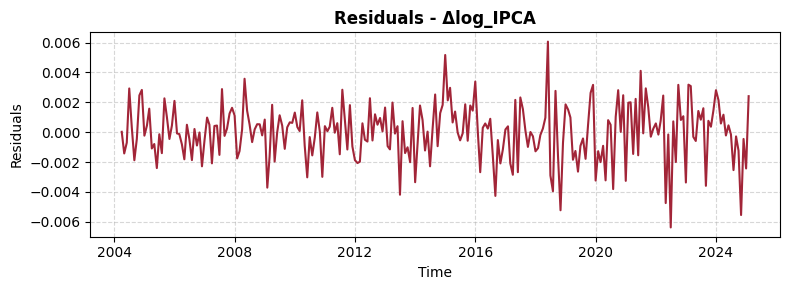

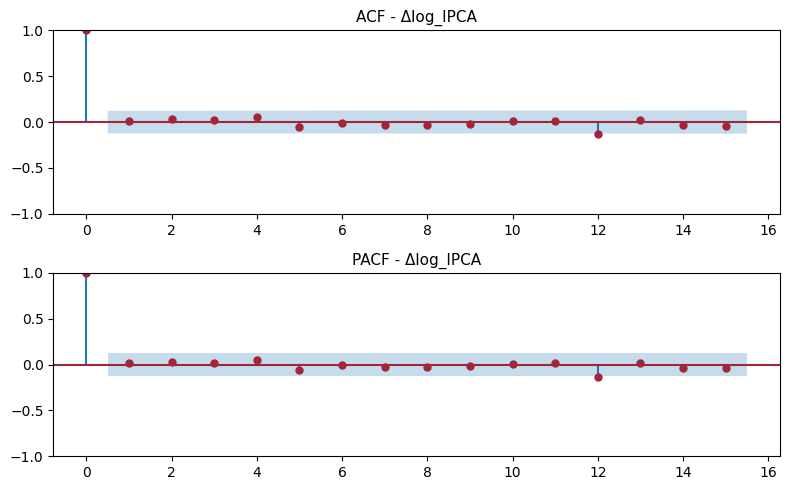

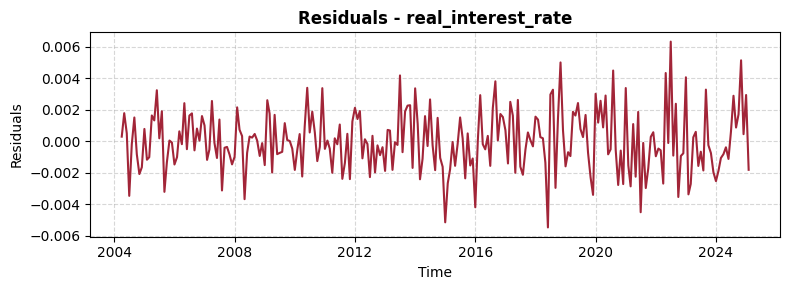

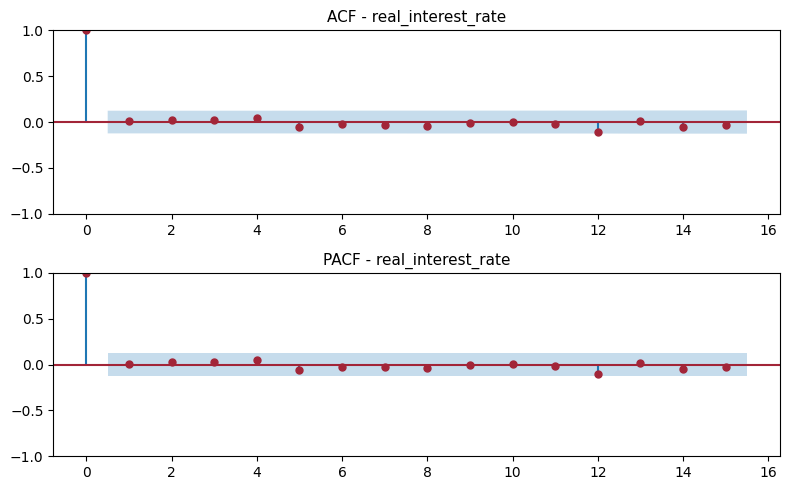

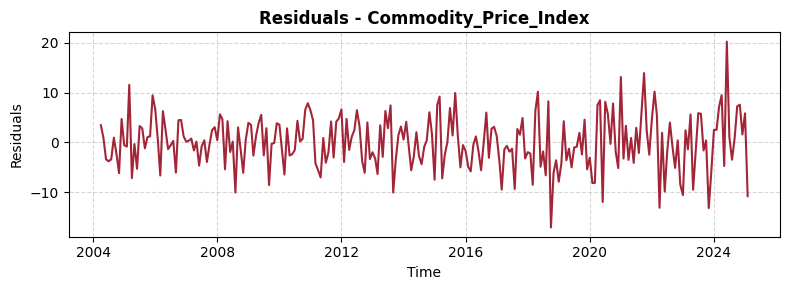

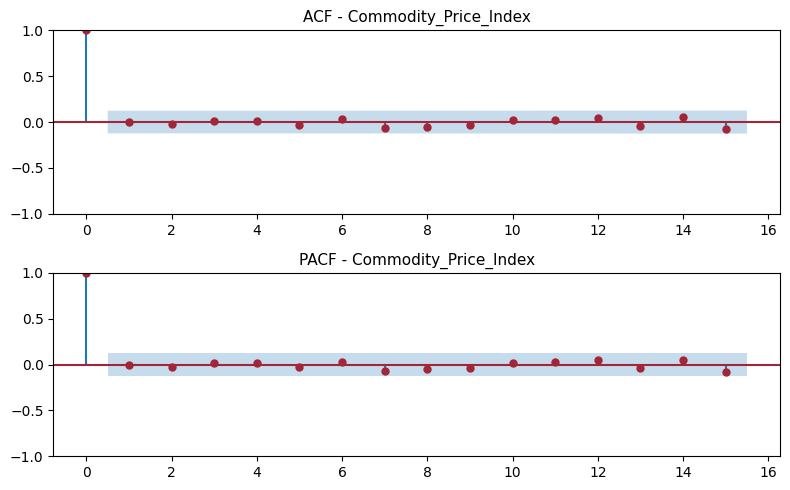

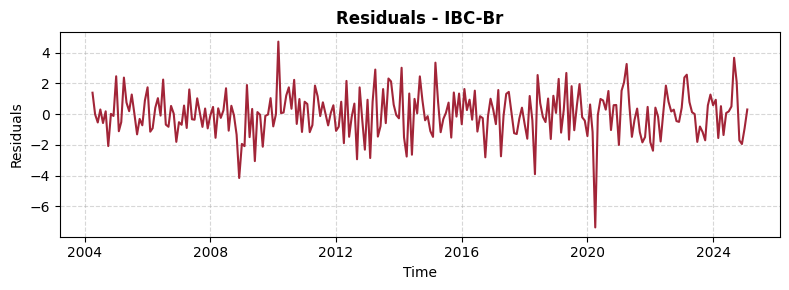

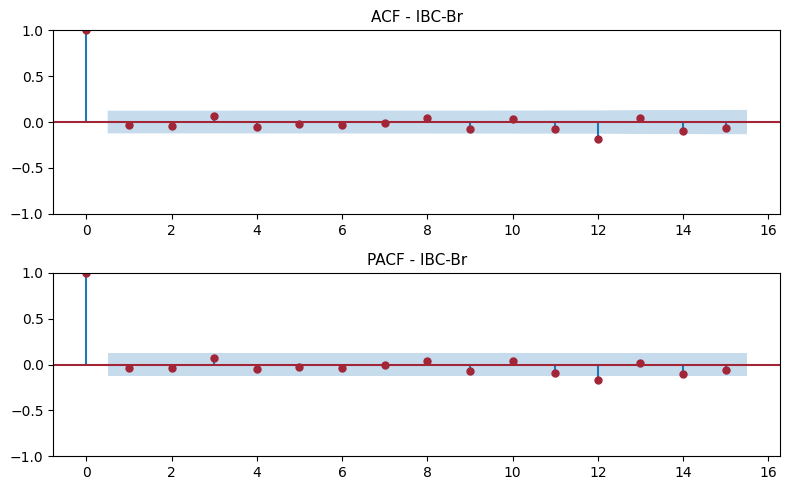

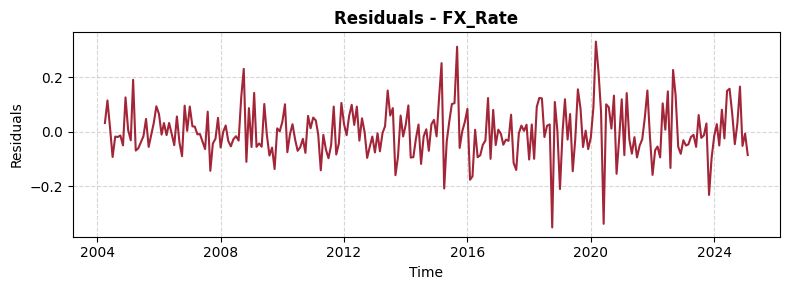

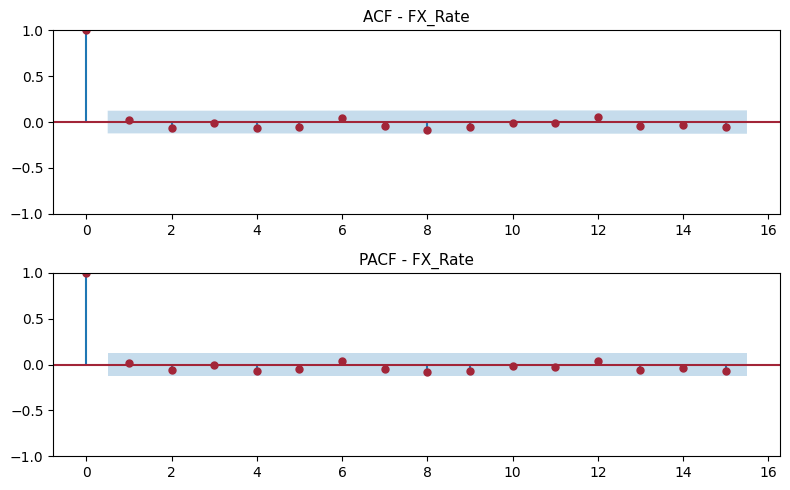

In [17]:
variables = ['Δlog_IPCA', 'real_interest_rate', 'Commodity_Price_Index', 'IBC-Br', 'FX_Rate']
plot_var_diagnostics(results, variables, lags=15, color= red_color)


In [18]:

# Since the VAR("lag") model accounts for autocorrelations up to "lag",
# we test for remaining autocorrelation starting from lag +1 onward.


port_test = results.test_whiteness(nlags= lags + 1)


p_value = port_test.pvalue


if p_value < 0.05:
    print(f"❌ Residuals fail Portmanteau test: serial correlation detected (p = {p_value:.3f})")
else:
    print(f"✅ Residuals pass Portmanteau test: no serial correlation detected (p = {p_value:.3f})")

print("\nFull test results:")
print(port_test.summary())

❌ Residuals fail Portmanteau test: serial correlation detected (p = 0.000)

Full test results:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 16 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         202.4          37.65   0.000 25
----------------------------------------


In [19]:

print(f"\nBreusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = {lag})\n")

# Loop over each equation in the VAR
for var in results.names:
    resids = results.resid[var]  # residuals for this equation
    lm_stat, lm_pvalue, _, _ = acorr_lm(resids, nlags=lag)
    
    # Interpret result
    if lm_pvalue < 0.05:
        print(f"❌ {var}: Serial correlation detected (LM test p = {lm_pvalue:.3f})")
    else:
        print(f"✅ {var}: No serial correlation (LM test p = {lm_pvalue:.3f})")


Breusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = 15)

✅ Δlog_IPCA: No serial correlation (LM test p = 0.891)
✅ real_interest_rate: No serial correlation (LM test p = 0.967)
✅ Commodity_Price_Index: No serial correlation (LM test p = 0.967)
✅ IBC-Br: No serial correlation (LM test p = 0.227)
✅ FX_Rate: No serial correlation (LM test p = 0.848)


#### Impose a recursive identification. If you have doubts about the ordering, consult Christiano, Eichenbaum, and Evans (1999) or CEE (2005). Justify the ordering.

#### Obtain the IRFs for a 36-month horizon with a confidence interval of 68% or 90%. Choose the method to obtain the CI for the IRF. Explain your results. In particular, what are the effects of a monetary policy shock on the economy? Any strange results?

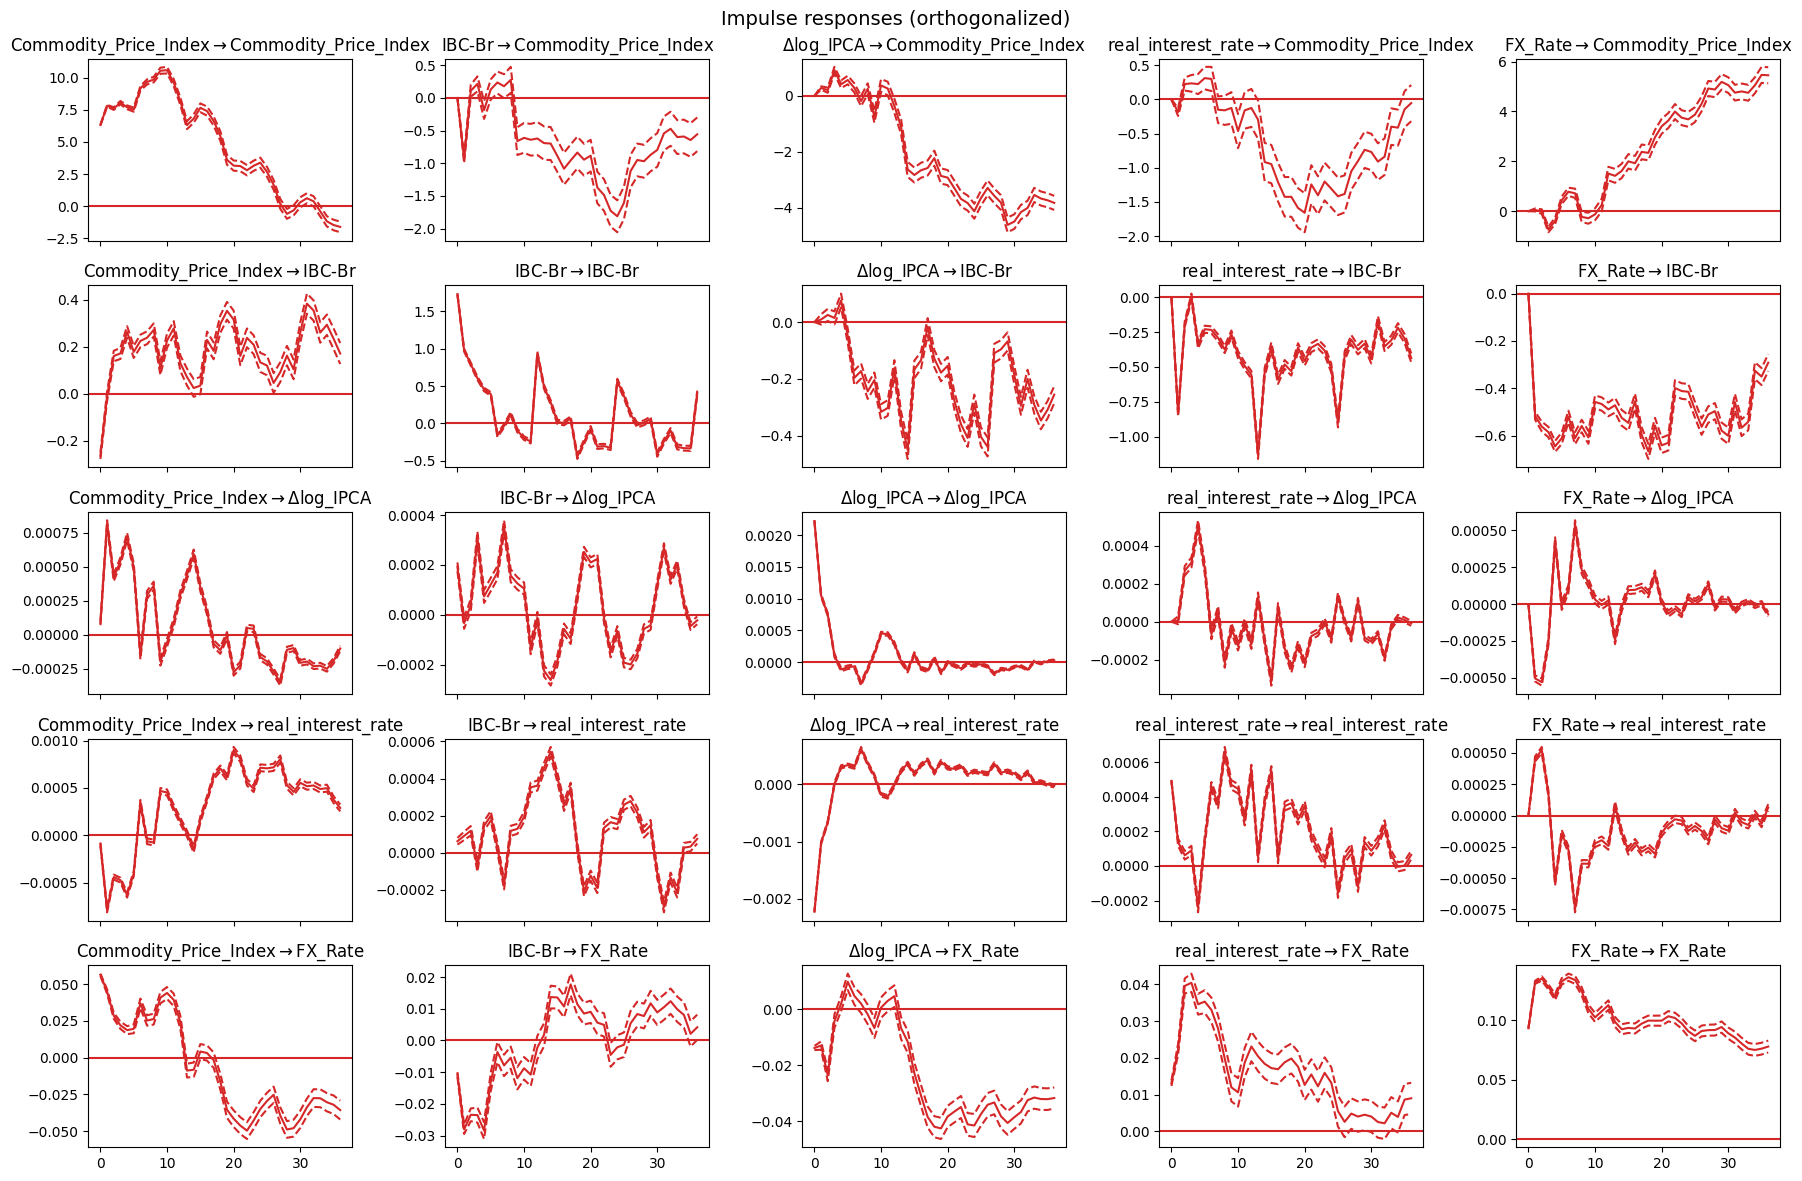

In [20]:
ordering = ['Commodity_Price_Index', 'IBC-Br','Δlog_IPCA','real_interest_rate','FX_Rate']
df_var_ordered = df_var[ordering]  # This sets the Cholesky order

# Estimate the VAR on the reordered data
model = VAR(df_var_ordered)
results = model.fit(lag, method='ols')

irf = results.irf(36)  # 36-month horizon

# Plot with red lines
fig = irf.plot(orth=True, signif=0.90)
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("#d62728")

fig.set_size_inches(18, 12)
plt.tight_layout()
plt.show()


#### Obtain the FEVD for 2, 6, 12, 18, 24, 36 months. What is the importance of monetary policy?

In [21]:
ordering = ['Commodity_Price_Index', 'IBC-Br','Δlog_IPCA','real_interest_rate','FX_Rate']
df_var_ordered = df_var[ordering]

# Estimate the VAR model
model = VAR(df_var_ordered)
results = model.fit(15)

fevd = results.fevd(36)  # 36-month horizon

print(fevd.summary())

FEVD for Commodity_Price_Index
      Commodity_Price_Index    IBC-Br  Δlog_IPCA  real_interest_rate   FX_Rate
0                  1.000000  0.000000   0.000000            0.000000  0.000000
1                  0.990259  0.008604   0.000781            0.000329  0.000026
2                  0.993122  0.005569   0.000762            0.000529  0.000018
3                  0.988589  0.004137   0.004287            0.000620  0.002366
4                  0.989532  0.003394   0.003999            0.000669  0.002406
5                  0.989432  0.002878   0.004274            0.000844  0.002573
6                  0.989590  0.002437   0.003610            0.000887  0.003476
7                  0.990311  0.002059   0.003024            0.000770  0.003836
8                  0.991483  0.001858   0.002652            0.000690  0.003316
9                  0.991300  0.002168   0.003012            0.000605  0.002915
10                 0.991584  0.002319   0.002775            0.000777  0.002544
11                 0.

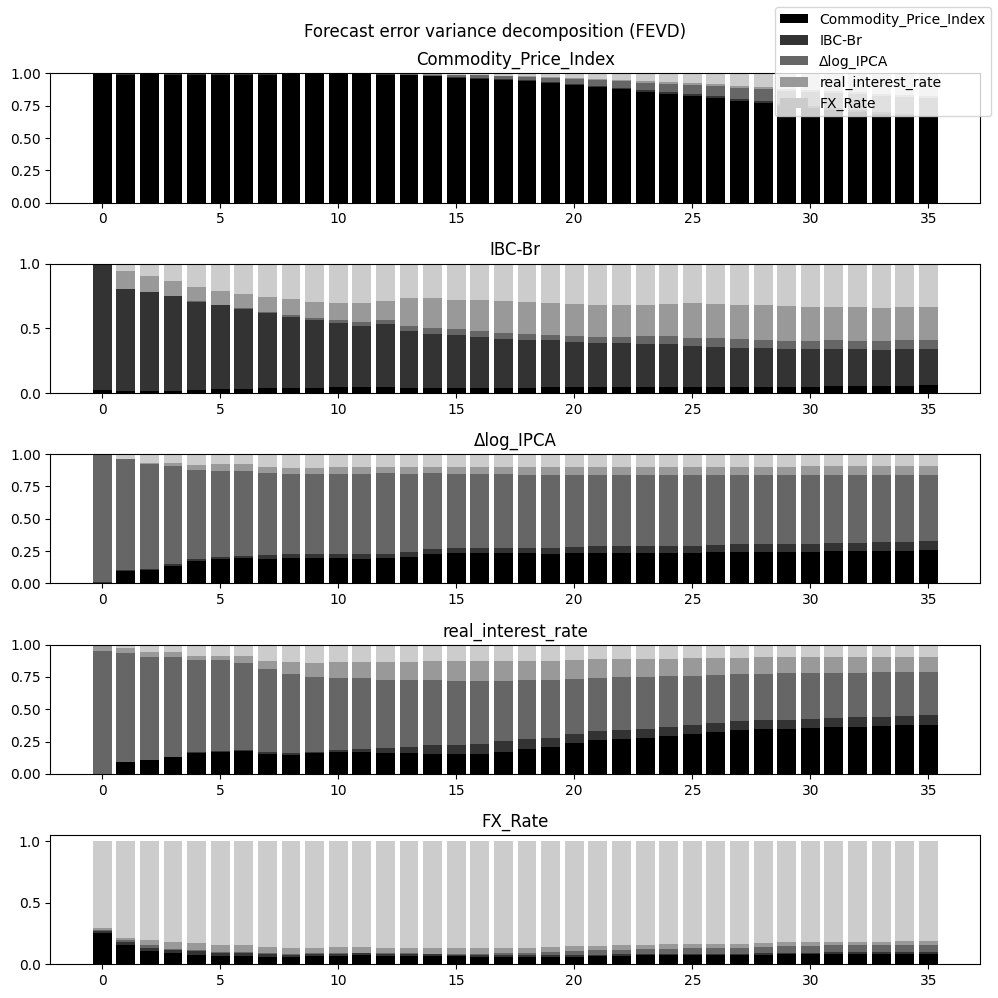

In [22]:
# Plot full FEVD for all variables (default behavior)
fevd.plot(36)  # 36 periods
plt.tight_layout()
plt.show()


### Question 2

Reestimate the VAR imposing sign restrictions. You must use Inflation (IPCA), real interest rate (the one you constructed), commodity price index, IBC-Br, and exchange rate. You may use either Uhlig (2005), Mountford and Uhlig (2009), or Arias et al. (2018) as a reference. Just choose one method and no need to explain it.

#### Data

In [23]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2805,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2806,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2807,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [24]:
# IPCA series

# Downloading the IPCA series from IPEA
df_ipca = ipea.timeseries('PRECOS12_IPCA12')

# Renaming columns for clarity
df_ipca = df_ipca.rename(columns={
    'RAW DATE': 'date',
    'VALUE (-)': 'IPCA',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Drop unnecessary columns
df_ipca = df_ipca.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Convert 'date' column to datetime (with timezone awareness handling)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], errors='coerce', utc=True)

# Set 'date' as index
df_ipca.set_index('date', inplace=True)

# Remove timezone to make index tz-naive (match other DataFrames)
df_ipca.index = df_ipca.index.tz_convert(None)
df_ipca.index = df_ipca.index.to_period('M').to_timestamp()

# Sort by date
df_ipca = df_ipca.sort_index()


# Apply log transformation to the IPCA column
df_ipca['log_IPCA'] = np.log(df_ipca['IPCA'])

# Calculate the first difference of the log
df_ipca['Δlog_IPCA'] = df_ipca['log_IPCA'].diff().round(5)


df_ipca['IPCA'] = df_ipca['IPCA'].round(5)

In [25]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation

# Apply log transformation
df_ibcbr['log_IBCBR'] = np.log(df_ibcbr['IBC-Br'])

# Calculate the first difference of the log
df_ibcbr['Δlog_IBC-Br'] = df_ibcbr['log_IBCBR'].diff().round(5)

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)

In [26]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

In [27]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()



# Apply log transformation to the IPCA column
df_commodity['log_Commodity_Price_Index'] = np.log(df_commodity['Commodity_Price_Index'])

# Calculate the first difference of the log
df_commodity['Δlog_CommodityPrice'] = df_commodity['log_Commodity_Price_Index'].diff().round(5)



df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)


In [28]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate', 
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()


# Apply log transformation to the IPCA column
df_fx['log_FX_Rate'] = np.log(df_fx['FX_Rate'])

# Calculate the first difference of the log
df_fx['Δlog_FX_Rate'] = df_fx['log_FX_Rate'].diff().round(5)


df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)


In [29]:
df = df_ibcbr.join([df_ipca, df_selic, df_commodity, df_fx], how='inner')

del df_ibcbr, df_ipca, df_selic, df_commodity, df_fx

In [30]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['Δlog_IPCA']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)


# Apply log transformation
df['Log_real_interest_rate'] = np.log(df['real_interest_rate'])

# Calculate the first difference of the log
df['ΔLog_real_interest_rate'] = df['Log_real_interest_rate'].diff().round(5)



df['real_interest_rate'] = df['real_interest_rate'].round(5)


In [31]:
# Select the variables of interest for the VAR
vars_var = df[['Δlog_IPCA', 'real_interest_rate', 'Δlog_CommodityPrice', 'Δlog_IBC-Br', 'Δlog_FX_Rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

Δlog_IPCA              0
real_interest_rate     0
Δlog_CommodityPrice    0
Δlog_IBC-Br            1
Δlog_FX_Rate           0
dtype: int64


#### Present in a table the imposed restrictions and indicate the time period you used to impose the restrictions.

Sign Restrictions for Monetary Policy Shock (Uhlig, 2005)

| Variable               | Expected Sign | Horizon (months) |
|------------------------|----------------|------------------|
| `real_interest_rate`   | **Positive**   | 0 to 6           |
| `IBC-Br`               | **Negative**   | 0 to 6          |
| `FX_Rate`              | **Free**   | -         |
| `Commodity_Price_Index`| **Free**   | -           |
| `monthly_inflation`    | **Negative**   | 0 to 6           |

In [32]:


# List of variables in the VAR (in correct ordering)
variables = df_var_ordered.columns.tolist()

# Residual covariance matrix
Sigma_u = results.sigma_u

# Cholesky decomposition of the covariance matrix
P = cholesky(Sigma_u)

# Define which shock we are identifying (e.g., monetary policy shock)
shock_var = 'real_interest_rate'
shock_pos = variables.index(shock_var)

# Number of candidate rotations and IRF horizon
n_draws = 20000
horizon = 36

# Store accepted IRFs that satisfy the sign restrictions
accepted_irfs = []

print("✔️ Setup complete. Ready to start drawing random rotations.")


✔️ Setup complete. Ready to start drawing random rotations.


In [33]:
print("🚀 Starting random rotation draws with variable-specific horizons...")

# Define sign restrictions as a dictionary: {var_name: (sign, start_t, end_t)}
# sign: +1 for positive, -1 for negative, 0 for free
sign_restrictions = {
    'real_interest_rate': (+1, 0, 6),
    'IBC-Br': (-1, 0, 6),
    'Δlog_IPCA': (-1, 0, 6)
}

for i in range(n_draws):
    Q = ortho_group.rvs(len(variables))  # random orthogonal matrix
    B = P @ Q
    irfs_rotated = results.irf(horizon).orth_irfs @ Q
    irf_monetary = irfs_rotated[:, :, shock_pos]

    is_valid = True
    for var_name, (expected_sign, start_t, end_t) in sign_restrictions.items():
        var_idx = variables.index(var_name)
        for t in range(start_t, end_t + 1):
            if expected_sign == +1 and irf_monetary[t, var_idx] <= 0:
                is_valid = False
                break
            elif expected_sign == -1 and irf_monetary[t, var_idx] >= 0:
                is_valid = False
                break
        if not is_valid:
            break

    if is_valid:
        accepted_irfs.append(irf_monetary)

    if i % 1000 == 0 and i > 0:
        print(f"Draw {i} → accepted IRFs so far: {len(accepted_irfs)}")

accepted_irfs = np.array(accepted_irfs)

print(f"\n✅ Total accepted draws: {accepted_irfs.shape[0]} out of {n_draws}")

🚀 Starting random rotation draws with variable-specific horizons...
Draw 1000 → accepted IRFs so far: 0
Draw 2000 → accepted IRFs so far: 0
Draw 3000 → accepted IRFs so far: 1
Draw 4000 → accepted IRFs so far: 2
Draw 5000 → accepted IRFs so far: 3
Draw 6000 → accepted IRFs so far: 3
Draw 7000 → accepted IRFs so far: 3
Draw 8000 → accepted IRFs so far: 3
Draw 9000 → accepted IRFs so far: 3
Draw 10000 → accepted IRFs so far: 3
Draw 11000 → accepted IRFs so far: 3
Draw 12000 → accepted IRFs so far: 5
Draw 13000 → accepted IRFs so far: 6
Draw 14000 → accepted IRFs so far: 7
Draw 15000 → accepted IRFs so far: 8
Draw 16000 → accepted IRFs so far: 9
Draw 17000 → accepted IRFs so far: 10
Draw 18000 → accepted IRFs so far: 10
Draw 19000 → accepted IRFs so far: 10

✅ Total accepted draws: 11 out of 20000


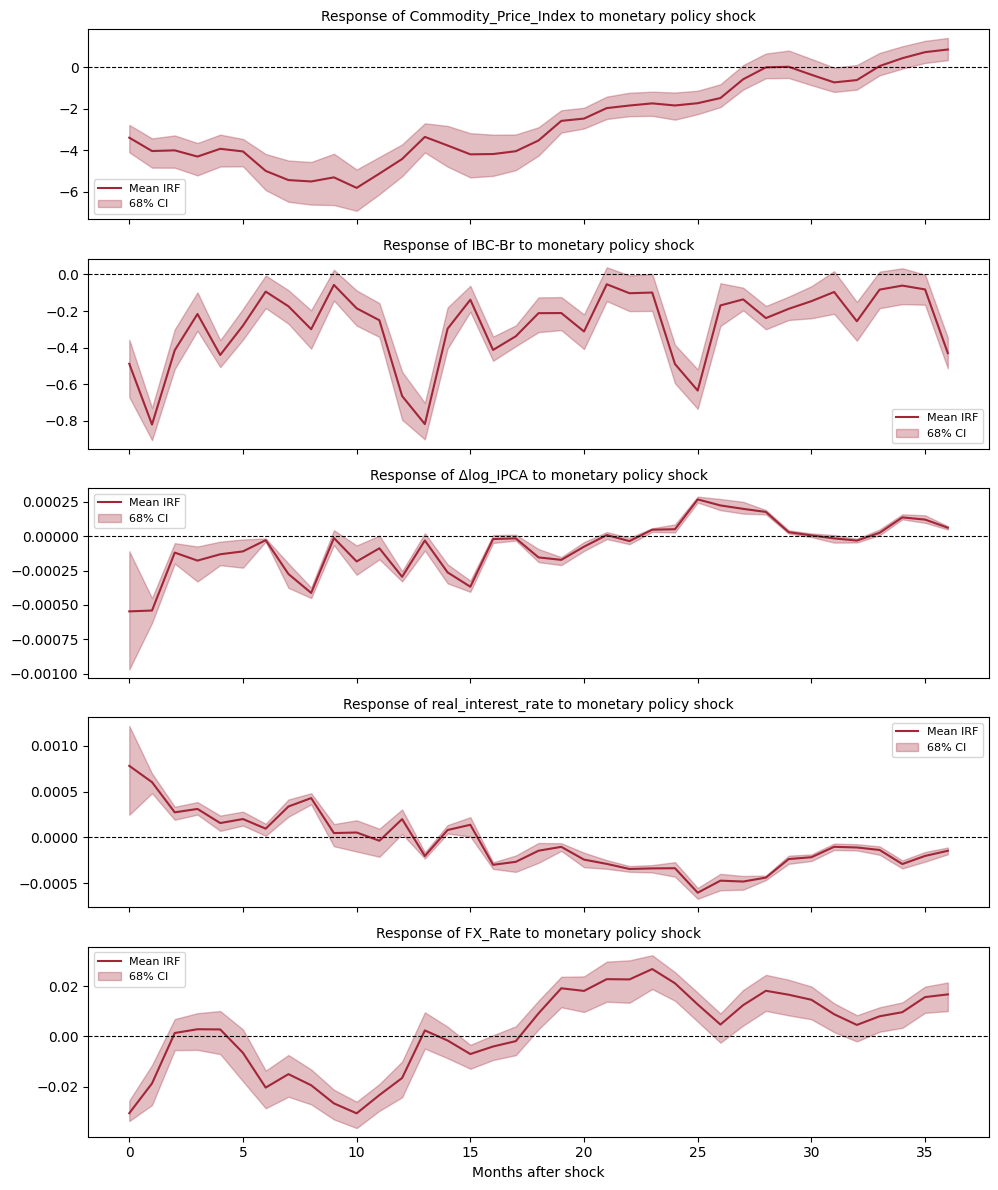

In [34]:
# Mean IRFs
mean_irfs = accepted_irfs.mean(axis=0)

# Confidence bands (16th and 84th percentiles)
lower_band = np.percentile(accepted_irfs, 16, axis=0)
upper_band = np.percentile(accepted_irfs, 84, axis=0)

# Plot each variable's response to the monetary policy shock
horizon_range = np.arange(mean_irfs.shape[0])  # [0, 1, ..., 35]
n_vars = mean_irfs.shape[1]

fig, axs = plt.subplots(n_vars, 1, figsize=(10, 12), sharex=True)

for i in range(n_vars):
    ax = axs[i]
    ax.plot(horizon_range, mean_irfs[:, i], color="#A22538", label="Mean IRF")
    ax.fill_between(horizon_range, lower_band[:, i], upper_band[:, i], color="#A22538", alpha=0.3, label="68% CI")
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title(f"Response of {variables[i]} to monetary policy shock", fontsize=10)
    ax.legend(fontsize=8, loc="best")
    # ax.grid(True, linestyle='--', alpha=0.4)  # ← removed

plt.xlabel("Months after shock")
plt.tight_layout()
plt.show()



In [35]:
# FEVD based on the mean IRFs from accepted draws
# mean_irfs: shape [horizon, n_vars]

# Range of horizons (e.g., from 1 to 36 months)
h_list = [2, 6, 12, 24, 36]
n_vars = mean_irfs.shape[1]
contribution_matrix = np.zeros((len(h_list), n_vars))

for h_idx, h in enumerate(h_list):
    for var_idx in range(n_vars):
        contribution_matrix[h_idx, var_idx] = np.sum(mean_irfs[:h+1, var_idx] ** 2)


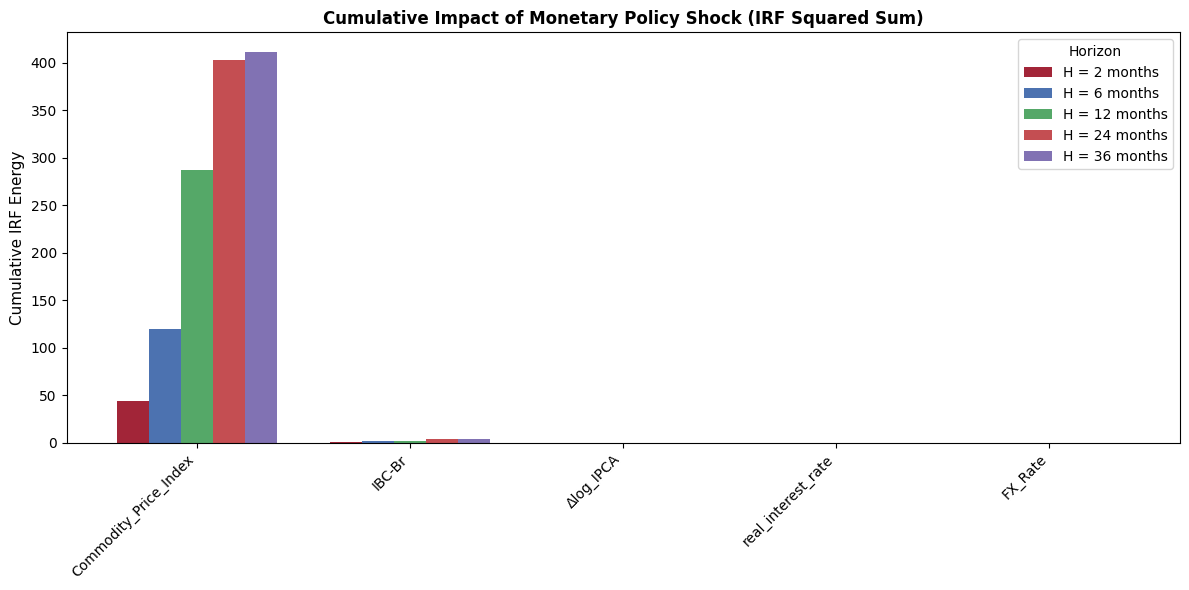

In [36]:
x = np.arange(len(variables))
bar_width = 0.15
offsets = [-2, -1, 0, 1, 2]

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#A22538', '#4C72B0', '#55A868', '#C44E52', '#8172B3']

for i, h in enumerate(h_list):
    ax.bar(x + offsets[i] * bar_width, contribution_matrix[i], 
           width=bar_width, label=f'H = {h} months', color=colors[i])

ax.set_xticks(x)
# ax.set_yscale("log")
ax.set_xticklabels(variables, rotation=45, ha="right", fontsize=10)
ax.set_ylabel("Cumulative IRF Energy", fontsize=11)
ax.set_title("Cumulative Impact of Monetary Policy Shock (IRF Squared Sum)", fontsize=12, fontweight="bold")
ax.legend(title="Horizon")
plt.tight_layout()
plt.show()



### Question 3

In this exercise, you are required to reproduce one of the VAR models presented in the September 2012 Inflation Report published by the Central Bank of Brazil (link to report, page 107).

The first VAR model replicates Model I from the report, while the second model partially reproduces Model III.

You must choose the best forecasting model using a model selection criterion.
Use the data starting from January 2000.

#### Data

In [3]:
# Here we use a keyword to search for available time series or browse them manually on the IPEA website
ipea.metadata()

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABATE_ABPEAV,Abate - aves - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Tonelada,mil,A,1,BRA,True
1,ABATE_ABQUBV,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T13:00:00.673-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Anual,Cabeça,mil,A,1,BRA,True
2,ABATE12_ABPEVA12,Abate - vacas - peso das carcaças,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Tonelada,mil,I,1,BRA,True
3,ABATE12_ABQUBO12,Abate - bois - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
4,ABATE12_ABQUBV12,Abate - bovinos - quantidade,O abate de animais é mensurado por sua quantid...,2025-03-18T12:26:00.49-03:00,Macroeconômico,IBGE/Coagro,Instituto Brasileiro de Geografia e Estatístic...,www.ibge.gov.br,Mensal,Cabeça,mil,A,1,BRA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,PNADCT_TXPARTCUF_SI,Taxa de participação - sem instrução ou equiva...,"Taxa de participação na força de trabalho, na ...",2025-02-18T12:24:51.957-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Trimestral,(%),None,None,110,None,True
2805,PNAD_IAGRV,Domicílios com insegurança alimentar grave,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.677-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2806,PNAD_IALEV,Domicílios com insegurança alimentar leve,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.68-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True
2807,PNAD_IAMOD,Domicílios com insegurança alimentar moderada,Distribuição percentual dos domicílios de acor...,2024-06-20T10:44:01.683-03:00,Social,IBGE/PNAD Contínua,Instituto Brasileiro de Geografia e Estatístic...,http://www.ibge.gov.br/home/estatistica/indica...,Decenal,(%),None,None,111,None,True


In [4]:
# Free_IPCA series

# Defining the series code and the date range
series_code = 11426
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_Free_IPCA = pd.read_json(url)

# Converting the 'date' column to datetime format
df_Free_IPCA['date'] = pd.to_datetime(df_Free_IPCA['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_Free_IPCA['valor'] = pd.to_numeric(df_Free_IPCA['valor'], errors='coerce')

# Renaming columns for clarity
df_Free_IPCA = df_Free_IPCA.rename(columns={
    'valor': 'Free_IPCA',
})

# Drop columns
df_Free_IPCA = df_Free_IPCA.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_Free_IPCA.set_index('date', inplace=True)
df_Free_IPCA.index = df_Free_IPCA.index.to_period('M').to_timestamp()

# Calculate monthly variation

# Apply log transformation
df_Free_IPCA['log_Free_IPCA'] = np.log(df_Free_IPCA['Free_IPCA'])

# Calculate the first difference of the log
df_Free_IPCA['Δlog_Free_IPCA'] = df_Free_IPCA['log_Free_IPCA'].diff().round(5)

df_Free_IPCA['Free_IPCA'] = df_Free_IPCA['Free_IPCA'].round(5)

In [5]:
# Admin_IPCA series

# Defining the series code and the date range
series_code = 11427
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_Admin_IPCA = pd.read_json(url)

# Converting the 'date' column to datetime format
df_Admin_IPCA['date'] = pd.to_datetime(df_Admin_IPCA['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_Admin_IPCA['valor'] = pd.to_numeric(df_Admin_IPCA['valor'], errors='coerce')

# Renaming columns for clarity
df_Admin_IPCA = df_Admin_IPCA.rename(columns={
    'valor': 'Admin_IPCA',
})

# Drop columns
df_Admin_IPCA = df_Admin_IPCA.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_Admin_IPCA.set_index('date', inplace=True)
df_Admin_IPCA.index = df_Admin_IPCA.index.to_period('M').to_timestamp()

# Calculate monthly variation

# Apply log transformation
df_Admin_IPCA['log_Admin_IPCA'] = np.log(df_Admin_IPCA['Admin_IPCA'])

# Calculate the first difference of the log
df_Admin_IPCA['Δlog_Admin_IPCA'] = df_Admin_IPCA['log_Admin_IPCA'].diff().round(5)

df_Admin_IPCA['Admin_IPCA'] = df_Admin_IPCA['Admin_IPCA'].round(5)

In [6]:
# IBC-Br series

# Defining the series code and the date range
series_code = 24363
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the JSON data directly from the API
df_ibcbr = pd.read_json(url)

# Converting the 'date' column to datetime format
df_ibcbr['date'] = pd.to_datetime(df_ibcbr['data'], format='%d/%m/%Y')

# Converting the 'valor' column to numeric type
df_ibcbr['valor'] = pd.to_numeric(df_ibcbr['valor'], errors='coerce')

# Renaming columns for clarity
df_ibcbr = df_ibcbr.rename(columns={
    'valor': 'IBC-Br',
})

# Drop columns
df_ibcbr = df_ibcbr.drop(columns=['data'], errors='ignore')

# Setting 'date' as the index
df_ibcbr.set_index('date', inplace=True)
df_ibcbr.index = df_ibcbr.index.to_period('M').to_timestamp()

# Calculate monthly variation

# Apply log transformation
df_ibcbr['log_IBCBR'] = np.log(df_ibcbr['IBC-Br'])

# Calculate the first difference of the log
df_ibcbr['Δlog_IBC-Br'] = df_ibcbr['log_IBCBR'].diff().round(5)

df_ibcbr['IBC-Br'] = df_ibcbr['IBC-Br'].round(5)

In [7]:
# SELIC Acum series

# Downloading the SELIC series from IPEA
df_selic = ipea.timeseries('BM12_TJOVER12')

# Renaming columns for clarity
df_selic = df_selic.rename(columns={
    'RAW DATE': 'date',
    'VALUE ((% a.m.))': 'SELIC',
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_selic = df_selic.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' column to datetime (handling timezone if needed)
df_selic['date'] = pd.to_datetime(df_selic['date'], errors='coerce', utc=True)

# Setting 'date' as the index
df_selic.set_index('date', inplace=True)

# Removing timezone to make the index tz-naive
df_selic.index = df_selic.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_selic.index = df_selic.index.to_period('M').to_timestamp()

# Sorting the DataFrame by date
df_selic = df_selic.sort_index()

# Convert SELIC to decimal
df_selic['selic_dec'] = df_selic['SELIC'] / 100

df_selic['SELIC'] = df_selic['SELIC'].round(5)
df_selic['selic_dec'] = df_selic['selic_dec'].round(5)

In [8]:
# Commodity price index series

commodity_code = 27574
start_date = '01/01/2000'
end_date = '31/12/2025'

# Building the API URL
url_commodity = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{commodity_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'

# Reading the data from the API
df_commodity = pd.read_json(url_commodity)

# Converting 'data' to datetime and 'valor' to numeric
df_commodity['data'] = pd.to_datetime(df_commodity['data'], format='%d/%m/%Y', utc=True)
df_commodity['valor'] = pd.to_numeric(df_commodity['valor'], errors='coerce')

# Renaming columns for clarity
df_commodity = df_commodity.rename(columns={'data': 'date', 'valor': 'Commodity_Price_Index'})

# Setting date as index
df_commodity.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_commodity.index = df_commodity.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_commodity.index = df_commodity.index.to_period('M').to_timestamp()

# Sorting by date
df_commodity = df_commodity.sort_index()



# Apply log transformation to the IPCA column
df_commodity['log_Commodity_Price_Index'] = np.log(df_commodity['Commodity_Price_Index'])

# Calculate the first difference of the log
df_commodity['Δlog_CommodityPrice'] = df_commodity['log_Commodity_Price_Index'].diff().round(5)



df_commodity['Commodity_Price_Index'] = df_commodity['Commodity_Price_Index'].round(5)


In [9]:
# Exchange rate series code (Dollar - commercial rate, selling)

# Downloading the series from IPEA
df_fx = ipea.timeseries('PAN12_ERV12')

# Renaming columns for clarity
df_fx = df_fx.rename(columns={
    'RAW DATE': 'date',
    'VALUE (R$)': 'FX_Rate', 
    'CODE': 'code',
    'DAY': 'day',
    'MONTH': 'month',
    'YEAR': 'year'
})

# Dropping unnecessary columns
df_fx = df_fx.drop(columns=['code', 'day', 'month', 'year'], errors='ignore')

# Converting 'date' to datetime with timezone handling
df_fx['date'] = pd.to_datetime(df_fx['date'], errors='coerce', utc=True)

# Setting 'date' as index
df_fx.set_index('date', inplace=True)

# Removing timezone to make index tz-naive
df_fx.index = df_fx.index.tz_convert(None)

# Converting index to monthly frequency (YYYY-MM-01)
df_fx.index = df_fx.index.to_period('M').to_timestamp()

# Sorting by date
df_fx = df_fx.sort_index()


# Apply log transformation to the IPCA column
df_fx['log_FX_Rate'] = np.log(df_fx['FX_Rate'])

# Calculate the first difference of the log
df_fx['Δlog_FX_Rate'] = df_fx['log_FX_Rate'].diff().round(5)


df_fx['FX_Rate'] = df_fx['FX_Rate'].round(5)


In [10]:
df = df_ibcbr.join([df_Admin_IPCA, df_Free_IPCA, df_selic, df_commodity, df_fx], how='inner')

del df_ibcbr, df_Admin_IPCA, df_selic, df_commodity, df_fx, df_Free_IPCA

In [11]:
# Calculate real interest rate using exact Fisher formula
df['real_interest_rate'] = (1 + df['selic_dec']) / (1 + df['Δlog_Free_IPCA']) - 1

df['real_interest_rate']  = df['real_interest_rate'].round(5)


# Apply log transformation
df['Log_real_interest_rate'] = np.log(df['real_interest_rate'])

# Calculate the first difference of the log
df['ΔLog_real_interest_rate'] = df['Log_real_interest_rate'].diff().round(5)



df['real_interest_rate'] = df['real_interest_rate'].round(5)


In [12]:
# Select the variables of interest for the VAR
vars_var = df[['Free_IPCA', 'Admin_IPCA', 'FX_Rate', 'real_interest_rate']]

# Check how many missing values there are in each column
print(vars_var.isna().sum())

Free_IPCA             0
Admin_IPCA            0
FX_Rate               0
real_interest_rate    2
dtype: int64


#### Model I

In [19]:
lags = 2


var1_vars = ['Free_IPCA', 'Admin_IPCA', 'FX_Rate', 'real_interest_rate']

df_var1 = df[var1_vars].dropna()


# Define the cutoff date
cutoff = '2023-12-01'

# Split into training and test sets
df_train = df_var1.loc[:cutoff]
df_test = df_var1.loc[cutoff:]



model_var1 = VAR(df_train)
results_var1 = model_var1.fit(lags, method='ols')

print(results_var1.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 15, mai, 2025
Time:                     10:09:54
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -8.41660
Nobs:                     248.000    HQIC:                  -8.72130
Log likelihood:          -264.687    FPE:                0.000132824
AIC:                     -8.92661    Det(Omega_mle):     0.000115173
--------------------------------------------------------------------
Results for equation Free_IPCA
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.067772         0.027131            2.498           0.012
L1.Free_IPCA                  0.515661         0.078923            6.534           0.000
L1.Admin_IPCA           

In [20]:
# Portmanteau test
port_test = results_var1.test_whiteness(nlags= lags + 1)
pval = port_test.pvalue

if pval < 0.05:
    print(f"❌ Serial correlation detected in residuals (p = {pval:.4f})")
else:
    print(f"✅ Residuals pass whiteness test (p = {pval:.4f})")

# Detalhes
print(port_test.summary())


✅ Residuals pass whiteness test (p = 0.0528)
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 3 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         26.09          26.30   0.053 16
----------------------------------------


In [21]:

print(f"\nBreusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = {lags})\n")

# Loop over each equation in the VAR
for var in results_var1.names:
    resids = results_var1.resid[var]  # residuals for this equation
    lm_stat, lm_pvalue, _, _ = acorr_lm(resids, nlags=lags)
    
    # Interpret result
    if lm_pvalue < 0.05:
        print(f"❌ {var}: Serial correlation detected (LM test p = {lm_pvalue:.3f})")
    else:
        print(f"✅ {var}: No serial correlation (LM test p = {lm_pvalue:.3f})")


Breusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = 2)

✅ Free_IPCA: No serial correlation (LM test p = 0.600)
✅ Admin_IPCA: No serial correlation (LM test p = 0.320)
✅ FX_Rate: No serial correlation (LM test p = 0.866)
✅ real_interest_rate: No serial correlation (LM test p = 1.000)


In [22]:
# Steps = number of periods in test set
n_forecast = len(df_test)

# Generate forecast
forecast = results_var1.forecast(df_train.values[-results_var1.k_ar:], steps=n_forecast)

# Convert to DataFrame
forecast_index = pd.date_range(start=df_train.index[-1] + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=var1_vars)

# Extract forecasted free_prices
free_prices_forecast = forecast_df[['Free_IPCA']]


In [26]:


rmse = np.sqrt(mean_squared_error(df_test['Free_IPCA'][:n_forecast], free_prices_forecast))
print(f"RMSE of free_prices forecast (VAR I): {rmse:.5f}")


RMSE of free_prices forecast (VAR I): 0.14696


In [ ]:

n_forecast_extended = 24  # de 2024-01 a 2025-12

forecast_extended = results_var1.forecast(
    df_train.values[-results_var1.k_ar:], 
    steps=n_forecast_extended
)


forecast_extended_index = pd.date_range(
    start=df_train.index[-1] + pd.offsets.MonthBegin(1), 
    periods=n_forecast_extended, 
    freq='MS'
)


forecast_extended_df = pd.DataFrame(forecast_extended, index=forecast_extended_index, columns=var1_vars)

free_prices_forecast_extended = forecast_extended_df[['Free_IPCA']]


In [ ]:
# in-sample
fitted_values = results_var1.fittedvalues


fitted_values.index = df_train.index[results_var1.k_ar:]


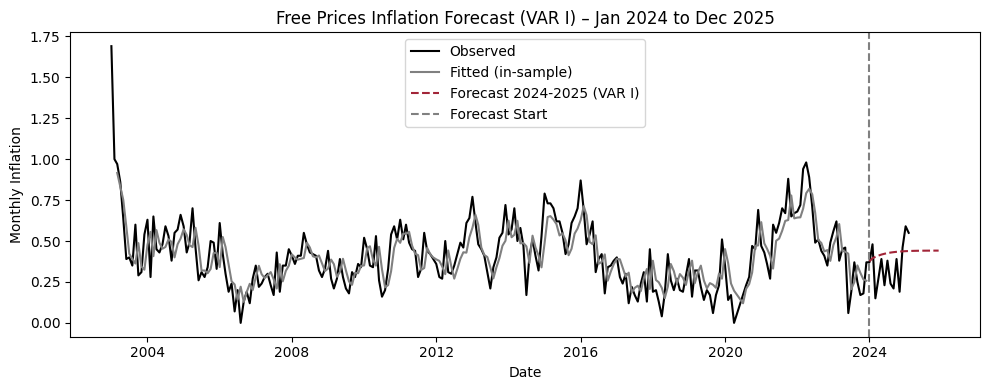

In [ ]:
plt.figure(figsize=(10, 4))


plt.plot(df_var1['Free_IPCA'], label='Observed', color='black')

# Fitted in-sample
plt.plot(fitted_values['Free_IPCA'], label='Fitted (in-sample)', color='gray', linestyle='-')

# Forecast out-of-sample (24 months)
plt.plot(free_prices_forecast_extended, label='Forecast 2024-2025 (VAR I)', color='#A22538', linestyle='--')


plt.axvline(free_prices_forecast_extended.index[0], color='gray', linestyle='--', label='Forecast Start')

plt.title("Free Prices Inflation Forecast (VAR I) – Jan 2024 to Dec 2025")
plt.xlabel("Date")
plt.ylabel("Monthly Inflation")
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
# Extrai os valores previstos entre 2025-01 e 2025-12
inflation_2025 = free_prices_forecast_extended.loc['2025-01':'2025-12', 'Free_IPCA']

In [36]:
# Select the 12 months of 2025
inflation_2025 = free_prices_forecast_extended.loc['2025-01':'2025-12', 'Free_IPCA']

# Convert from percentage to factor and calculate accumulated inflation
accumulated_inflation = (np.prod(1 + inflation_2025 / 100) - 1) * 100

print(f"📈 Forecasted accumulated inflation (Jan–Dec 2025): {accumulated_inflation:.2f}%")

📈 Forecasted accumulated inflation (Jan–Dec 2025): 5.42%


#### Model III

In [60]:
lags = 3


var3_vars = ['Free_IPCA', 'IBC-Br', 'real_interest_rate']

df_var3 = df[var3_vars].dropna()


# Define the cutoff date
cutoff = '2023-12-01'

# Split into training and test sets
df_train = df_var3.loc[:cutoff]
df_test = df_var3.loc[cutoff:]


from statsmodels.tsa.seasonal import STL

# Ajusta sazonalmente todas as variáveis do VAR III
df_train_sa = df_train.copy()

for col in df_train.columns:
    stl = STL(df_train[col], period=12, robust=True)
    result = stl.fit()
    df_train_sa[col] = result.trend + result.resid  # remove o componente sazonal


model_var3 = VAR(df_train_sa)
results_var3 = model_var3.fit(lags, method='ols')

print(results_var3.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 15, mai, 2025
Time:                     10:20:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  0.0999003
Nobs:                     247.000    HQIC:                 -0.154733
Log likelihood:          -981.130    FPE:                   0.721655
AIC:                    -0.326341    Det(Omega_mle):        0.640650
--------------------------------------------------------------------
Results for equation Free_IPCA
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.016302         0.079872            0.204           0.838
L1.Free_IPCA                  0.546667         0.063966            8.546           0.000
L1.IBC-Br               

In [61]:
# Portmanteau test
port_test = results_var3.test_whiteness(nlags= lags + 1)
pval = port_test.pvalue

if pval < 0.05:
    print(f"❌ Serial correlation detected in residuals (p = {pval:.4f})")
else:
    print(f"✅ Residuals pass whiteness test (p = {pval:.4f})")

# Detalhes
print(port_test.summary())


❌ Serial correlation detected in residuals (p = 0.0133)
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 4 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         20.86          16.92   0.013  9
----------------------------------------


In [62]:

print(f"\nBreusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = {lags})\n")

# Loop over each equation in the VAR
for var in results_var3.names:
    resids = results_var3.resid[var]  # residuals for this equation
    lm_stat, lm_pvalue, _, _ = acorr_lm(resids, nlags=lags)
    
    # Interpret result
    if lm_pvalue < 0.05:
        print(f"❌ {var}: Serial correlation detected (LM test p = {lm_pvalue:.3f})")
    else:
        print(f"✅ {var}: No serial correlation (LM test p = {lm_pvalue:.3f})")


Breusch-Godfrey (LM) Test for Serial Correlation in Residuals (lag = 3)

✅ Free_IPCA: No serial correlation (LM test p = 0.863)
✅ IBC-Br: No serial correlation (LM test p = 0.263)
✅ real_interest_rate: No serial correlation (LM test p = 1.000)


In [63]:
# Steps = number of periods in test set
n_forecast = len(df_test)

# Generate forecast
forecast = results_var3.forecast(df_train.values[-results_var3.k_ar:], steps=n_forecast)

# Convert to DataFrame
forecast_index = pd.date_range(start=df_train.index[-1] + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=var3_vars)

# Extract forecasted free_prices
free_prices_forecast = forecast_df[['Free_IPCA']]


In [64]:


rmse = np.sqrt(mean_squared_error(df_test['Free_IPCA'][:n_forecast], free_prices_forecast))
print(f"RMSE of free_prices forecast (VAR I): {rmse:.5f}")


RMSE of free_prices forecast (VAR I): 0.13039


In [ ]:

n_forecast_extended = 24  # de 2024-01 a 2025-12


forecast_extended = results_var3.forecast(
    df_train.values[-results_var3.k_ar:], 
    steps=n_forecast_extended
)

# Índice temporal da previsão
forecast_extended_index = pd.date_range(
    start=df_train.index[-1] + pd.offsets.MonthBegin(1), 
    periods=n_forecast_extended, 
    freq='MS'
)


forecast_extended_df = pd.DataFrame(forecast_extended, index=forecast_extended_index, columns=var3_vars)


free_prices_forecast_extended = forecast_extended_df[['Free_IPCA']]


In [ ]:
# in-sample
fitted_values = results_var3.fittedvalues


fitted_values.index = df_train.index[results_var3.k_ar:]


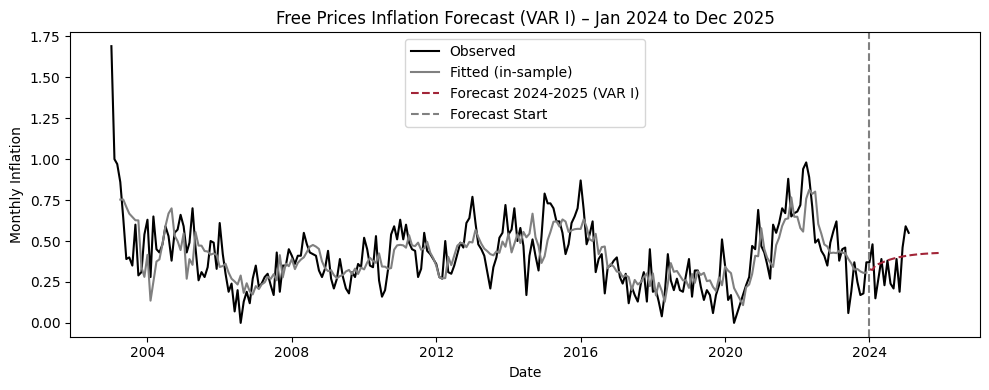

In [67]:
plt.figure(figsize=(10, 4))


plt.plot(df_var3['Free_IPCA'], label='Observed', color='black')

# Fitted in-sample
plt.plot(fitted_values['Free_IPCA'], label='Fitted (in-sample)', color='gray', linestyle='-')

# Forecast out-of-sample (24 months)
plt.plot(free_prices_forecast_extended, label='Forecast 2024-2025 (VAR I)', color='#A22538', linestyle='--')


plt.axvline(free_prices_forecast_extended.index[0], color='gray', linestyle='--', label='Forecast Start')

plt.title("Free Prices Inflation Forecast (VAR I) – Jan 2024 to Dec 2025")
plt.xlabel("Date")
plt.ylabel("Monthly Inflation")
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
# Extrai os valores previstos entre 2025-01 e 2025-12
inflation_2025 = free_prices_forecast_extended.loc['2025-01':'2025-12', 'Free_IPCA']

In [69]:
# Select the 12 months of 2025
inflation_2025 = free_prices_forecast_extended.loc['2025-01':'2025-12', 'Free_IPCA']

# Convert from percentage to factor and calculate accumulated inflation
accumulated_inflation = (np.prod(1 + inflation_2025 / 100) - 1) * 100

print(f"📈 Forecasted accumulated inflation (Jan–Dec 2025): {accumulated_inflation:.2f}%")

📈 Forecasted accumulated inflation (Jan–Dec 2025): 5.15%
